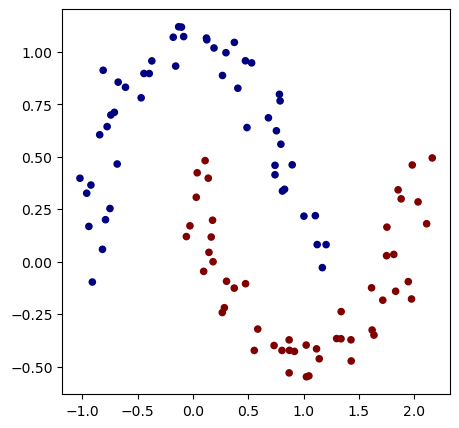

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from shrimpgrad import Tensor, nn, dtypes
import random

np.random.seed(1337)
random.seed(1337)
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
X = X.astype(float)
y = y.astype(float)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


In [31]:
X_train = Tensor.fromlist(X.shape, X.flatten().tolist())
y_train = Tensor.fromlist((100,1), y.flatten().tolist())
class Model:
    def __init__(self):
        self.layers: List[Callable[[Tensor], Tensor]] = [
         nn.Linear(2, 50), Tensor.relu,
         nn.Linear(50, 1), Tensor.sigmoid, 
        ]
    def __call__(self, x: Tensor):
        return x.sequential(self.layers)

In [32]:
def get_parameters(model):
    params = []
    for layer in model.layers:
        if getattr(layer, 'parameters', None):
            params+=layer.parameters()
    return params
def optimize(model, x_train, target, epochs=1000, lr=0.01):
    epsilon = 1e-10
    for epoch in range(epochs):
        params = get_parameters(model)
        for p in params: p.grad = None
        out = model(x_train)
        loss = out.binary_cross_entropy(target)
        numerator = ((target > 0) == (out > 0.5)).sum().cast(dtypes.float32)
        accuracy = (numerator / out.size(0)) * 100.0
        loss.backward()
        print(f'epoch={epoch} loss={loss} acc={accuracy}')
        lr = 3.0 - 0.9*epoch/epochs
        for param in params:
            param.data = (param - (param.grad*lr)).data
    return model
optimize(model:=Model(), X_train, y_train, epochs=80, lr=0.1)

epoch=0 loss=tensor(0.6902823314593727) acc=tensor(50.0)
epoch=1 loss=tensor(0.5874017098456444) acc=tensor(75.0)
epoch=2 loss=tensor(0.9486306841652766) acc=tensor(50.0)
epoch=3 loss=tensor(1.1021409642790838) acc=tensor(50.0)
epoch=4 loss=tensor(0.4807197617080299) acc=tensor(84.0)
epoch=5 loss=tensor(0.3443196095864073) acc=tensor(83.0)
epoch=6 loss=tensor(0.31881372048042184) acc=tensor(85.0)
epoch=7 loss=tensor(0.3016394915824584) acc=tensor(86.0)
epoch=8 loss=tensor(0.28700114400876936) acc=tensor(87.0)
epoch=9 loss=tensor(0.2739160871820911) acc=tensor(87.0)
epoch=10 loss=tensor(0.26249856409794986) acc=tensor(87.0)
epoch=11 loss=tensor(0.2523658675135939) acc=tensor(88.0)
epoch=12 loss=tensor(0.24387580789339455) acc=tensor(89.0)
epoch=13 loss=tensor(0.23633450766640138) acc=tensor(89.0)
epoch=14 loss=tensor(0.22958523743093864) acc=tensor(90.0)
epoch=15 loss=tensor(0.22309989984477185) acc=tensor(91.0)
epoch=16 loss=tensor(0.21672953013249707) acc=tensor(91.0)
epoch=17 loss=te

(-1.548639298268643, 1.951360701731357)

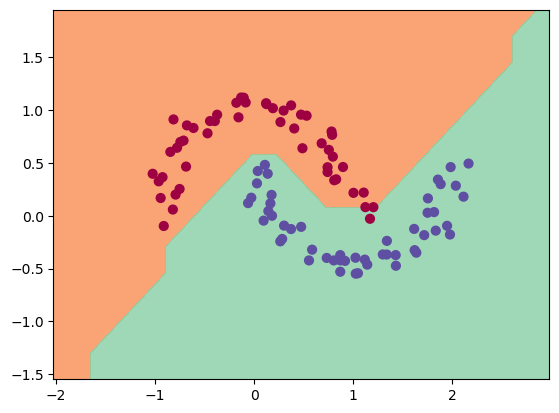

In [42]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
input_ = Tensor.fromlist(Xmesh.shape, data=Xmesh.flatten().tolist())
scores = model(input_)
Z = np.array([s > 0.5 for s in scores.data])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
